<a href="https://colab.research.google.com/github/yiwenwangANU/Tensorflow_Certificate/blob/main/Tensorflow_Certificate_Model_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bidirectional LSTM with Concatenated model

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
import os

os.listdir(data_dir)

['test.txt', 'dev.txt', 'train.txt']

In [5]:
train_dir = os.path.join(data_dir, 'train.txt')
test_dir = os.path.join(data_dir, 'dev.txt')

In [6]:
with open(train_dir, 'r') as f:
  raw_data_train = f.readlines() 

with open(test_dir, 'r') as f:
  raw_data_test = f.readlines() 

In [7]:
def sort_article(data):
  data_list = []
  article = []
  for line in data:
    article.append(line)
    if line.isspace():
      data_list.append(article)
      article = []
  return data_list

In [8]:
def to_dic_list(data):

  data_list = sort_article(data)
  data_dir_list = []
  for article in data_list:
    for i, line in enumerate(article[1:len(article)-1]):
      data_dir = {}
      line_split = line.split('\t')
      data_dir['target'] = line_split[0]
      data_dir['text'] = line_split[1].strip()
      data_dir['total_lines'] = len(article)-3
      data_dir['line_number'] = i
      data_dir_list.append(data_dir)
  return data_dir_list

In [9]:
train_list = to_dic_list(raw_data_train)
test_list = to_dic_list(raw_data_test)

In [10]:
train_df = pd.DataFrame(train_list)
test_df = pd.DataFrame(test_list)

In [11]:
train_text = train_df['text'].to_numpy() 
train_target = train_df['target'].to_numpy()
train_line_numbers = train_df['line_number'].to_numpy()
train_total_lines = train_df['total_lines'].to_numpy()

In [12]:
test_text = test_df['text'].to_numpy() 
test_target = test_df['target'].to_numpy()
test_line_numbers = test_df['line_number'].to_numpy()
test_total_lines = test_df['total_lines'].to_numpy()

In [13]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
train_target_le = le.fit_transform(train_df['target'].to_list())
test_target_le = le.transform(test_df['target'].to_list())

In [14]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def evaluate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_result = {'model_accuracy': model_accuracy,
                  'model_precision': model_precision,
                  'model_recall': model_recall,
                  'model_fscore': model_fscore}
  return model_result

Token vectorizaion mean length: 26.34
Length that cover 95% of the samples: 55


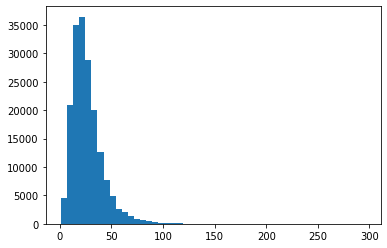

In [15]:
sentences_length_token = [len(sentences.split()) for sentences in train_df['text'].to_list()]
plt.hist(sentences_length_token, bins=50)
print(f'Token vectorizaion mean length: {np.mean(sentences_length_token):.2f}')
output_sen_len_token = int(np.percentile(sentences_length_token, 95))
print(f'Length that cover 95% of the samples: {output_sen_len_token}')

Character vectorizaion mean length: 149.37
Length that cover 95% of the samples: 290


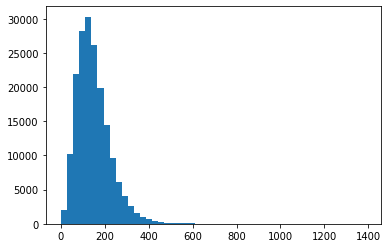

In [16]:
sentences_length_char = [len(sentences) for sentences in train_df['text'].to_list()]
plt.hist(sentences_length_char, bins=50)
print(f'Character vectorizaion mean length: {np.mean(sentences_length_char):.2f}')
output_sen_len_char = int(np.percentile(sentences_length_char, 95))
print(f'Length that cover 95% of the samples: {output_sen_len_char}')

In [17]:
token_vectorizer = layers.TextVectorization(max_tokens=68000,
                                            output_sequence_length=output_sen_len_token,
                                            name='token_vectorizer')
token_vectorizer.adapt(train_text)

In [18]:
char_vectorizer = layers.TextVectorization(max_tokens=50,
                                           output_sequence_length=output_sen_len_char,
                                           split='character',
                                           name='char_vectorizer')
char_vectorizer.adapt(train_text)

In [19]:
max_length_line_number = np.percentile(train_line_numbers, 95)
max_length_total_lines = np.percentile(train_total_lines, 95)

In [20]:
max_length_line_number, max_length_total_lines

(13.0, 18.0)

In [21]:
train_line_numbers_one_hot = tf.one_hot(train_line_numbers, depth=16)
test_line_numbers_one_hot = tf.one_hot(test_line_numbers, depth=16)

In [22]:
train_total_lines_one_hot = tf.one_hot(train_total_lines, depth=20)
test_total_lines_one_hot = tf.one_hot(test_total_lines, depth=20)

In [24]:
vocab_size_token = len(token_vectorizer.get_vocabulary())
vocab_size_char = len(char_vectorizer.get_vocabulary())
embedding_dims_char = 24
embedding_dims_token = 128
LSTM_units = 64
cnn_filters = 64
kernel_size = 5
output_dims = len(le.classes_)

In [26]:
text_inputs = layers.Input(shape=(1,), dtype='string')
char_vector = char_vectorizer(text_inputs)
char_embed = layers.Embedding(input_dim=vocab_size_char,
                              output_dim=embedding_dims_char,
                              mask_zero=True)(char_vector)
char_outputs = layers.Bidirectional(layers.LSTM(LSTM_units))(char_embed)
char_model = tf.keras.Model(text_inputs, char_outputs)

text_inputs = layers.Input(shape=(1,), dtype='string')
token_vector = token_vectorizer(text_inputs)
token_embed = layers.Embedding(input_dim=vocab_size_token,
                               output_dim=embedding_dims_token,
                               mask_zero=True)(token_vector)
token_outputs = layers.Bidirectional(layers.LSTM(LSTM_units))(token_embed)
token_model = tf.keras.Model(text_inputs, token_outputs)

line_number_inputs = layers.Input(shape=(16,), dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

token_char_concat = layers.Concatenate(name='token_char_concat')([char_model.output,
                                                                  token_model.output])
token_char_dense = layers.Dense(256, activation='relu')(token_char_concat)
token_char_dropout = layers.Dropout(0.5)(token_char_dense)

all_concat = layers.Concatenate(name='all_concat')([token_char_dropout,
                                                    line_number_model.output,
                                                    total_line_model.output])
output_layer = layers.Dense(output_dims)(all_concat)

model_2 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_line_model.input],
                         outputs=output_layer)

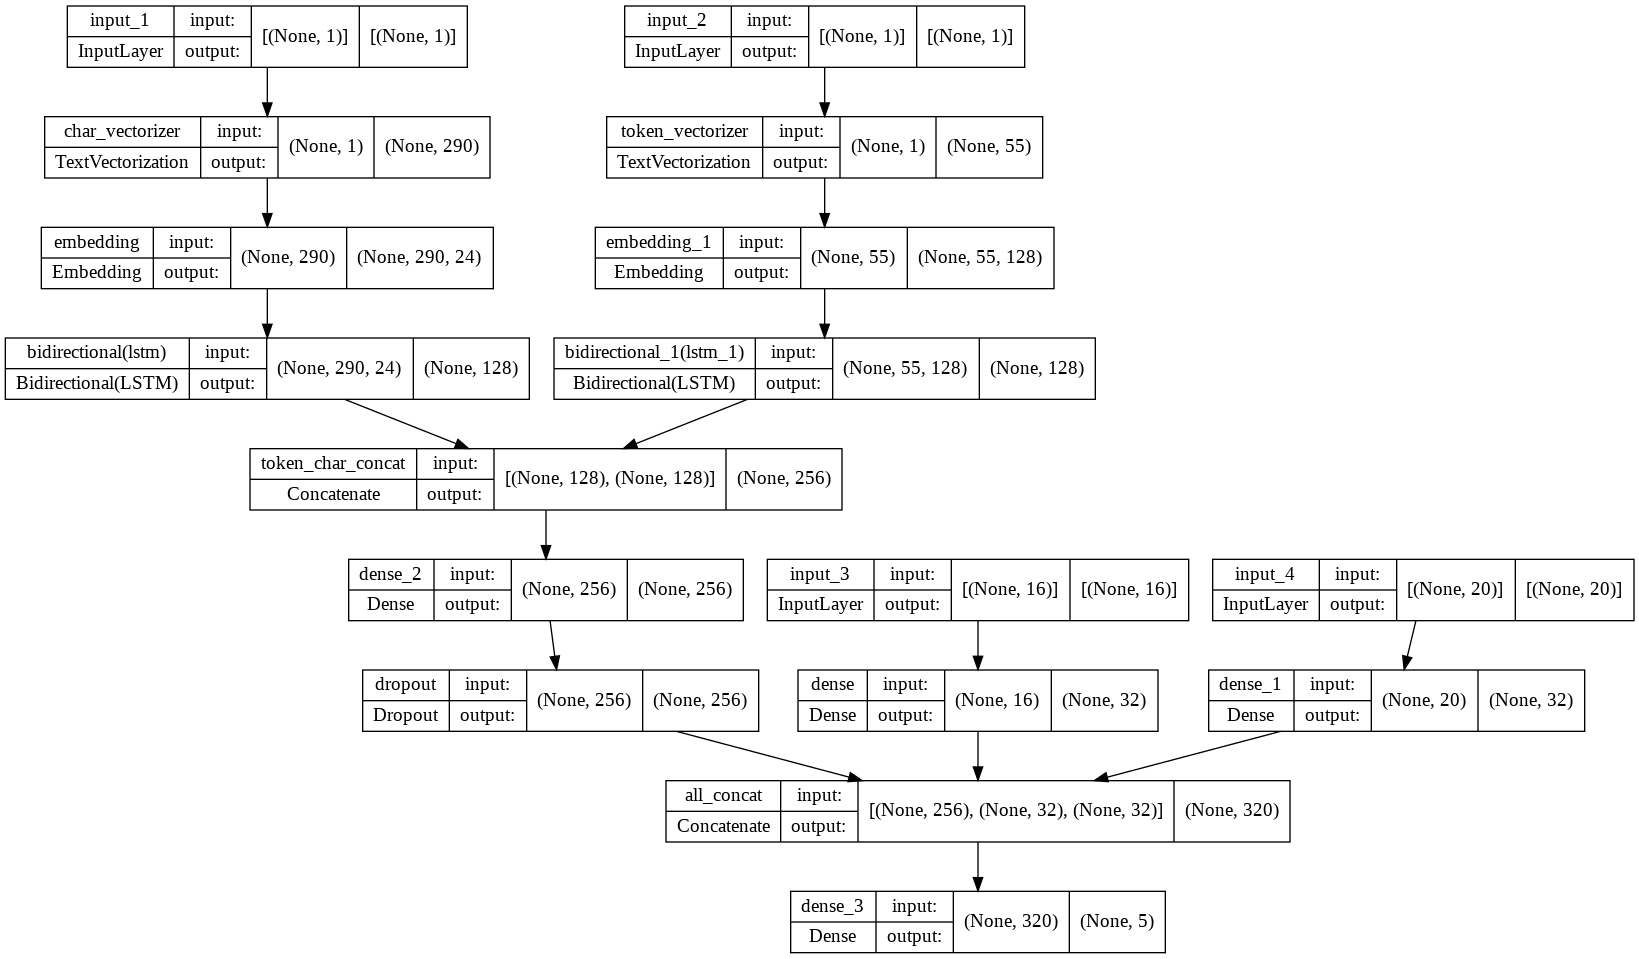

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, show_shapes=True)

In [28]:
train_concat_input = tf.data.Dataset.from_tensor_slices((train_text,
                                                         train_text,
                                                         train_line_numbers_one_hot,
                                                         train_total_lines_one_hot))
train_label = tf.data.Dataset.from_tensor_slices(train_target_le)
train_dataset_concat = tf.data.Dataset.zip((train_concat_input, train_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
test_concat_input = tf.data.Dataset.from_tensor_slices((test_text,
                                                        test_text,
                                                        test_line_numbers_one_hot,
                                                        test_total_lines_one_hot))
test_label = tf.data.Dataset.from_tensor_slices(test_target_le)
test_dataset_concat = tf.data.Dataset.zip((test_concat_input, test_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [61]:
train_concat_input

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(16,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

In [31]:
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [32]:
history_2 = model_2.fit(train_dataset_concat,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset_concat)),
                        validation_data=test_dataset_concat,
                        validation_steps=int(0.1*(len(test_dataset_concat))))

Epoch 1/3
562/562 [==============================] - 362s 612ms/step - loss: 0.6866 - accuracy: 0.7343 - val_loss: 0.4550 - val_accuracy: 0.8348
Epoch 2/3
562/562 [==============================] - 365s 649ms/step - loss: 0.4382 - accuracy: 0.8401 - val_loss: 0.4191 - val_accuracy: 0.8305
Epoch 3/3
562/562 [==============================] - 383s 681ms/step - loss: 0.3982 - accuracy: 0.8485 - val_loss: 0.3845 - val_accuracy: 0.8497


#Evaluation

In [39]:
model_2.evaluate(test_dataset_concat)

945/945 [==============================] - 103s 108ms/step - loss: 0.3817 - accuracy: 0.8502


[0.38172683119773865, 0.8501588702201843]

In [121]:
pred_pros = model_2.predict(test_dataset_concat)
pred_pros

array([[ 2.5619519 , -2.823979  , -2.3851016 ,  3.1435158 , -4.662818  ],
       [ 1.6023132 , -1.1199312 , -3.0602255 ,  1.6120697 , -4.583798  ],
       [ 2.023659  , -3.8113563 , -2.3228364 ,  3.6546202 , -6.370938  ],
       ...,
       [-5.750687  ,  0.9264402 ,  1.2089107 , -7.9861555 ,  6.1930976 ],
       [-1.652374  ,  3.8933506 , -3.0618467 , -3.7376018 ,  0.39106873],
       [-0.78821343,  3.4702783 , -2.6109796 , -3.476771  , -0.9028644 ]],
      dtype=float32)

In [125]:
test_preds = tf.argmax(pred_pros, axis=1)
test_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 1, 1])>

In [122]:
test_target_le[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [126]:
evaluate_results(test_target_le, test_preds)

{'model_accuracy': 0.850158877267311,
 'model_fscore': 0.8503310742111122,
 'model_precision': 0.8520094874365313,
 'model_recall': 0.850158877267311}

#Predict on test data

In [155]:
#Predict on dataset
example_dataset = tf.data.Dataset.zip((test_concat_input, test_label)).batch(1).take(1)
pred_pro = model_2.predict(example_dataset)
example_dataset, pred_pro

(<TakeDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 array([[ 2.561952 , -2.8239787, -2.3851013,  3.1435158, -4.6628175]],
       dtype=float32))

In [156]:
test_concat_input.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(16,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

In [157]:
#Predict on tensor
for input, _, line_number, total_lines in test_concat_input.take(1):
  pred_pro = model_2((tf.expand_dims(input, axis=0),
                      tf.expand_dims(input, axis=0),
                      tf.expand_dims(line_number, axis=0),
                      tf.expand_dims(total_lines, axis=0)))
  print(pred_pro)

tf.Tensor([[ 2.561952  -2.8239787 -2.3851013  3.1435158 -4.6628175]], shape=(1, 5), dtype=float32)


In [158]:
#Predict on text + line number + total line
test_df.head()

,target,text,total_lines,line_number
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,9,0
1,BACKGROUND,It is not clear whether these patients would b...,9,1
2,OBJECTIVE,We sought to determine whether a @-month cours...,9,2
3,METHODS,Asthmatic patients who were IgE sensitized to ...,9,3
4,METHODS,Primary outcomes were improvement in quality o...,9,4


In [159]:
example_string = test_df.loc[0, 'text']
example_total_lines = test_df.loc[0, 'total_lines']
example_line_number = test_df.loc[0, 'line_number']

print(f'Input String: {example_string}')
print(f'Total lines: {example_total_lines}, Line number: {example_line_number}')

Input String: IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .
Total lines: 9, Line number: 0


In [161]:
line_number_one_hot = tf.one_hot(example_line_number, 16)
total_lines_one_hot = tf.one_hot(example_total_lines, 20)

In [162]:
pred_pro = model_2((tf.expand_dims(example_string, axis=0),
                    tf.expand_dims(example_string, axis=0),
                    tf.expand_dims(line_number_one_hot, axis=0),
                    tf.expand_dims(total_lines_one_hot, axis=0)))
print(pred_pro)

tf.Tensor([[ 2.561952  -2.8239787 -2.3851013  3.1435158 -4.6628175]], shape=(1, 5), dtype=float32)


In [163]:
def make_prediction(input_string, line_number, total_lines):

  line_number_one_hot = tf.one_hot(line_number, 16)
  total_lines_one_hot = tf.one_hot(total_lines, 20)
  
  pred_pro = model_2((tf.expand_dims(input_string, axis=0),
                    tf.expand_dims(input_string, axis=0),
                    tf.expand_dims(line_number_one_hot, axis=0),
                    tf.expand_dims(total_lines_one_hot, axis=0)))

  return pred_pro

In [164]:
make_prediction(example_string,
                example_line_number,
                example_total_lines)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 2.561952 , -2.8239787, -2.3851013,  3.1435158, -4.6628175]],
      dtype=float32)>